In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1 Million row subset of train.csv 
train_df = pd.read_csv("./Data/train.csv", nrows=1_000_000)
weather_df = pd.read_csv("./Data/weather_train.csv")
building_df = pd.read_csv("./Data/building_metadata.csv")

R²: 0.9922
RMSE: 23.35
MAE: 8.17


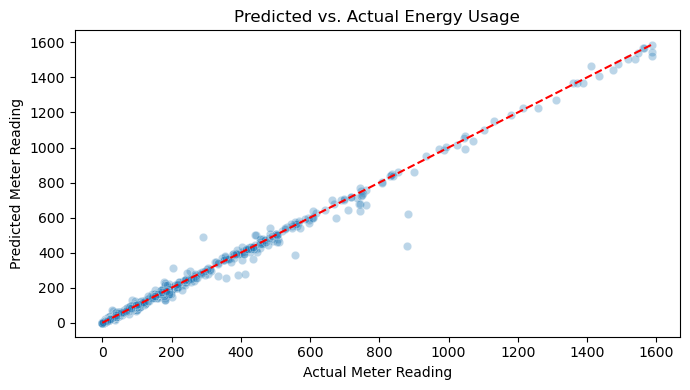

In [3]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], errors='coerce')
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], errors='coerce')
train_df = train_df.dropna(subset=['timestamp'])
weather_df = weather_df.dropna(subset=['timestamp'])

if 'site_id' not in train_df.columns:
    train_df = pd.merge(train_df, building_df[['building_id', 'site_id']], on='building_id', how='left')
    
merged = pd.merge(train_df, weather_df, on=['site_id', 'timestamp'], how='left')

full_df = pd.merge(merged, building_df, on='building_id', how='left')

full_df = full_df[full_df['meter'] == 0]

full_df['hour'] = full_df['timestamp'].dt.hour
full_df['weekday'] = full_df['timestamp'].dt.weekday
full_df['log_square_feet'] = np.log1p(full_df['square_feet'])

full_df = full_df.dropna(subset=[
    'meter_reading', 'air_temperature', 'dew_temperature',
    'wind_speed', 'primary_use', 'square_feet'
])

le = LabelEncoder()
full_df['primary_use'] = le.fit_transform(full_df['primary_use'])

features = [
    'air_temperature', 'dew_temperature', 'cloud_coverage',
    'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
    'wind_speed', 'primary_use', 'log_square_feet', 'year_built',
    'floor_count', 'hour', 'weekday'
]
target = 'meter_reading'

full_df = full_df.dropna(subset=features)
X = full_df[features]
y = full_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train model
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = np.mean(np.abs(y_test - y_pred))

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# dump model to data
joblib.dump(model, "./Data/hvac_energy_model.pkl")

plt.figure(figsize=(7, 4))
sns.scatterplot(x=y_test[:1000], y=y_pred[:1000], alpha=0.3)
plt.plot([0, max(y_test[:1000])], [0, max(y_test[:1000])], color='red', linestyle='--')
plt.xlabel("Actual Meter Reading")
plt.ylabel("Predicted Meter Reading")
plt.title("Predicted vs. Actual Energy Usage")
plt.tight_layout()
plt.show()